In [1]:
def read_file(path: str):
    def parse_data(line: str) -> list[(int, int)]:
        data = list(map(int, line.split()))
        coordinates = []
        for i in range(data[0]):
            coordinates.append((data[i*2 + 1]-1, data[(i+1)*2]-1))
        return coordinates
    
    with open(path, 'r') as f:
        board_size = tuple(map(int, f.readline().split()))
        walls = parse_data(f.readline())
        boxes = parse_data(f.readline())
        storages = parse_data(f.readline())
        player = tuple(map(lambda x: int(x)-1, f.readline().split()))
        
    return board_size, walls, boxes, storages, player

def visualize(data):
    board_size, walls, boxes, storages, player = data
    board = [[' '] * board_size[1] for _ in range(board_size[0])]
    for r, c in walls:
        board[r][c] = '#'
    for r, c in boxes:
        board[r][c] = '$'
    for r, c in storages:
        board[r][c] = '.'
    board[player[0]][player[1]] = '@'
    
    for r in board:
        print(''.join(r))
    
data = read_file('sokoban01.txt')
visualize(data)

########
#. #   #
#  $   #
#   # ##
## # $.#
#   $  #
#  .# @#
########


In [2]:
import collections
import random
import numpy as np
from copy import deepcopy

class Reward:
    STEP = -0.1
    BOX_ON_STORAGE = 1.0
    BOX_OFF_STORAGE = -1.0
    ALL_ON_STORAGE = 10.0
    DEADLOCK = -10.0
    MOVE_TO_WALL = -1.0

class Obj:
    EMPTY = 0
    STORAGE = 1
    PLAYER = 2
    PLAYER_ON_STORAGE = 3
    WALL = 4
    BOX = 5
    BOX_ON_STORAGE = 6

class QLearning:
    def __init__(self, board_size, walls, boxes, storages, player, max_step, eps, eps_decay_rate):
        self.Q = collections.defaultdict(lambda:np.zeros(4))
        self.eps = eps
        self.eps_decay_rate = eps_decay_rate
        self.num_step = 0
        self.max_step = max_step
        self.board_size = board_size
        self.walls = frozenset(walls)
        self.storages = frozenset(storages)
        self.state = (frozenset(boxes), player)
        self.init_state = (frozenset(boxes), player)
        self.board = [[0] * self.board_size[1] for _ in range(self.board_size[0])]
        for box in boxes:
            self.board[box[0]][box[1]] += Obj.BOX
        self.board[player[0]][player[1]] += Obj.PLAYER
        for wall in walls:
            self.board[wall[0]][wall[1]] += Obj.WALL
        for storage in storages:
            self.board[storage[0]][storage[1]] += Obj.STORAGE
        
        self.move = {
            0: (0, -1), # Left
            1: (-1, 0), # Up
            2: (0, 1),   # Right
            3: (1, 0),  # Down
        }
        
        self.direction = {
            0: "L",
            1: "U",
            2: "R",
            3: "D"
        }
        
    def isDeadlock(self):
        for box in self.state[0]:
            if (self.board[box[0]][box[1]] != Obj.BOX_ON_STORAGE and
                (self.board[box[0]+1][box[1]] == Obj.WALL and 
                self.board[box[0]][box[1]+1] == Obj.WALL or
                self.board[box[0]][box[1]+1] == Obj.WALL and 
                self.board[box[0]-1][box[1]] == Obj.WALL or
                self.board[box[0]-1][box[1]] == Obj.WALL and 
                self.board[box[0]][box[1]-1] == Obj.WALL or
                self.board[box[0]][box[1]-1] == Obj.WALL and 
                self.board[box[0]+1][box[1]] == Obj.WALL)):
                return True
        return False
    
    def getNextState(self, action):
        self.num_step += 1
        if self.isDeadlock() or self.isFinished() or self.num_step == self.max_step:
            self.num_step = 0
            self.updateState(self.init_state)
            
        reward = Reward.STEP
        ahead = np.sum([self.state[1], self.move[action]], axis=0)
        next_state = self.state
        
        if self.board[ahead[0]][ahead[1]] <= Obj.STORAGE:
            # Ahead is empty or storage. Move the player.
            next_state = (self.state[0], tuple(ahead))
        elif self.board[ahead[0]][ahead[1]] >= Obj.BOX:
            # Box or Box on storage. Check whether pushable.
            double_ahead = np.sum([ahead, self.move[action]], axis=0)
            
            if self.board[double_ahead[0]][double_ahead[1]] <= Obj.STORAGE:
                # Double ahead is empty or empty storage. Push the box.

                # Add reward for the box.
                if self.board[ahead[0]][ahead[1]] == Obj.BOX_ON_STORAGE:
                    reward += Reward.BOX_OFF_STORAGE
                if self.board[double_ahead[0]][double_ahead[1]] == Obj.STORAGE:
                    reward += Reward.BOX_ON_STORAGE
                    if len(self.state[0] - self.storages) == 1:
                        reward += Reward.ALL_ON_STORAGE
                        
                elif (self.board[double_ahead[0]+1][double_ahead[1]] == Obj.WALL and 
                    self.board[double_ahead[0]][double_ahead[1]+1] == Obj.WALL or
                    self.board[double_ahead[0]][double_ahead[1]+1] == Obj.WALL and 
                    self.board[double_ahead[0]-1][double_ahead[1]] == Obj.WALL or
                    self.board[double_ahead[0]-1][double_ahead[1]] == Obj.WALL and 
                    self.board[double_ahead[0]][double_ahead[1]-1] == Obj.WALL or
                    self.board[double_ahead[0]][double_ahead[1]-1] == Obj.WALL and 
                    self.board[double_ahead[0]+1][double_ahead[1]] == Obj.WALL):
                    reward += Reward.DEADLOCK
                
                # Move the player.
                next_player = tuple(ahead)
                # Update box list
                boxes = list(self.state[0])
                boxes.remove(tuple(ahead))
                boxes.append(tuple(double_ahead))
                next_boxes = frozenset(boxes)
                
                next_state = (next_boxes, next_player)
            else:
                # Can't move because of the wall
                reward += Reward.MOVE_TO_WALL
        else:
            # Can't move because of the wall
            reward += Reward.MOVE_TO_WALL
        
        return next_state, reward
    
    def updateState(self, next_state):
        boxes, player = self.state
        for box in boxes:
            self.board[box[0]][box[1]] -= Obj.BOX
        self.board[player[0]][player[1]] -= Obj.PLAYER
        
        self.state = next_state
        boxes, player = self.state
        for box in boxes:
            self.board[box[0]][box[1]] += Obj.BOX
        self.board[player[0]][player[1]] += Obj.PLAYER

    def getAction(self, eps):
        if np.random.random_sample() < eps:
            # Random move
            action = np.random.randint(0, 4)
        else:
            # Pick the best action
            action = np.argmax(self.Q[self.state])
        return action
    
    def isFinished(self):
        if self.state[0] == self.storages:
            self.eps *= self.eps_decay_rate
            return True
        else:
            return False
    
    def visualize(self):
        symbols = {
            0: ' ',
            1: '.',
            2: '#',
            3: '@',
            4: '@',
            5: '$',
            6: '$'
        }
        for r in self.board:
            print(''.join(map(lambda x:symbols[x], r)))
        print()

In [3]:
def solve(input_file, alpha=1.0, gamma=1.0, max_iter=100000, eps=0.9, eps_decay_rate=0.9,printOpt=True):
    
    board_size, walls, boxes, storages, player = read_file(input_file)
    max_step = board_size[0]*board_size[1]*len(boxes)
    
    solver = QLearning(board_size, walls, boxes, storages, player, max_step, eps, eps_decay_rate)

    last_episode = ""
    num_stalls = 0
    num_iters_to_converge = -1
    
    #from tqdm import tqdm
    for i in range(max_iter):#tqdm(range(max_iter)):
        # Periodic evaluation for early stopping
        if i % 100 == 0:
            nsteps, episode = inference(solver)
            if nsteps >= 0 and last_episode == episode:
                num_stalls += 1
            else:
                num_stalls = 0
            if num_stalls >= 5:
                # Conclude the policy has converged if it stalls for 100 times
                num_iters_to_converge = i
                break
            last_episode = episode
        # Training
        action = solver.getAction(solver.eps)
        next_state, reward = solver.getNextState(action)
        solver.Q[solver.state][action] = solver.Q[solver.state][action] + alpha*(reward + gamma*np.amax(solver.Q[next_state]) - solver.Q[solver.state][action])
        solver.updateState(next_state)

    length, episode = inference(solver, printOpt)
    print(f"# iters to converge: {num_iters_to_converge}")
    print(f"# explored states: {len(solver.Q)}")
    print(f"{length} {episode}")
    
    return num_iters_to_converge, len(solver.Q), length, episode
    
def inference(solver, visualize=False):
    eps = 0.0 # Greedy policy
    orig_state = solver.state
    solver.updateState(solver.init_state)
    moves = []
    len_moves, episode = -1, "Failed finding goal"
    for i in range(solver.max_step):
        action = solver.getAction(eps)
        moves.append(solver.direction[action])
        next_state, reward = solver.getNextState(action)
        if visualize:
            print(f"best action: {solver.direction[action]}")
            print(solver.Q[solver.state])
            solver.updateState(next_state)
            solver.visualize()
        else:
            solver.updateState(next_state)
        if solver.isFinished():
            len_moves = len(moves)
            episode = ''.join(moves)
            break
    
    solver.updateState(orig_state)
    return len_moves, episode
    

In [4]:
import numpy as np
def parameter_tuning(file_name='sokoban01.txt', tuning_step=3):
    board_size, walls, boxes, storages, player = read_file(file_name)
    max_step = board_size[0]*board_size[1]*len(boxes)
    opt_a=[]
    opt_g=[]
    opt_eps_d=[]
    total_performance=[]
    for i in range(0,tuning_step):
        performance = {}
        for alpha in np.arange(0.2, 1.1, 0.2): #param alpha tuning from 0.2 to 1
            for gamma in np.arange(0.2,1.1,0.2): #param gamma tuning from 0.2 to 1
                for eps_decay_rate in np.arange(0.5,1,0.1): #param eps_decay_rate tuning from 0.5 to 1
                    alpha = round(alpha,2) ;gamma = round(gamma,2) ; eps_decay_rate = round(eps_decay_rate,2)
                    print(alpha,gamma,eps_decay_rate)
                    num_step, len_q , len_move, _ = solve(file_name,alpha=alpha, gamma=gamma, eps_decay_rate=eps_decay_rate,printOpt=False)
                    performance[alpha,gamma,eps_decay_rate] = [num_step, len_q, len_move]
        total_performance.append(performance)
        #sort valeus by length of episode first and then iteration number, only considering the converged case
        opt_alpha, opt_gamma, opt_eps_decay_rate = [k for k, v in sorted(performance.items(), key=lambda item: (item[1][2],item[1][0],item[1][1])) if v[-1] != -1][0]
        opt_a.append(opt_alpha)
        opt_g.append(opt_gamma)
        opt_eps_d.append(opt_eps_decay_rate)
    return total_performance, opt_a, opt_g, opt_eps_d

In [5]:
def visualize_param_tuning(file_path,performance,fixed_col,fixed_value):
    col_name={'alpha':0,'gamma':1,'eps_decay rate':2}
    col_id = {v:k for k,v in col_name.items() }
    fixed_col_num= col_name[fixed_col]
    check_col_x,check_col_y= [i for i in col_name.values() if i != fixed_col_num]
    board_size, walls, boxes, storages, player = read_file(file_path)
    max_step = board_size[0]*board_size[1]*len(boxes)
    revised_perf = {k: v if v[0]!= -1 else [100000,v[1], max_step] for k, v in performance.items()}
    
    #normalize values
    max_step = max([v[0] for v in revised_perf.values()]) ; min_step = min([v[0] for v in revised_perf.values()])
    max_length = max([v[-1] for v in revised_perf.values()]); min_length = min([v[-1] for v in revised_perf.values()])
    step = {k:(v[0]-min_step) /(max_step-min_step) for k,v in revised_perf.items() if k[fixed_col_num]==fixed_value}
    length = {k: (v[-1]-min_length) /(max_length-min_length) for k,v in revised_perf.items() if k[fixed_col_num]==fixed_value}
    g_e_relations ={}
    for k in step.keys():
        if k in g_e_relations:
            g_e_relations[(k[check_col_x],k[check_col_y])] += 0.2 * step[k] + 0.8* length[k]
        else:
            g_e_relations[(k[check_col_x],k[check_col_y])] = 0.2* step[k] + 0.8* length[k]
    x_range = [round(i*0.1,2) for i in np.arange(2,11,2)] 
    if fixed_col_num !=2 :
        y_range = [round(i*0.1,2) for i in np.arange(5,10,1)] 
    else:
        y_range = [round(i*0.1,2) for i in np.arange(2,11,2)]
        
    tr_auc = np.zeros((len(x_range),len(y_range)))
    for i,k in enumerate(x_range):
        for j,a in enumerate(y_range):
            if g_e_relations[round(k,2),round(a,2)] == 1 :
                tr_auc[i][j] = None
            else:
                tr_auc[i][j] = g_e_relations[round(k,2),round(a,2)]
                
    import matplotlib.pyplot as plt
    f, ax = plt.subplots(1, 1, figsize=(8, 5))
    cax = ax.matshow(tr_auc, interpolation='nearest')
    f.colorbar(cax)
    ax.set_xlabel(f'{col_id[check_col_x]} values')
    ax.set_ylabel(f'{col_id[check_col_y]} values')
    ax.set_xticklabels(['']+list(x_range))
    ax.set_yticklabels(['']+list(y_range))
    plt.title(f"Performance of each {col_id[check_col_x]} and {col_id[check_col_y]} values")
    plt.show()

0.2 0.2 0.5
# iters to converge: 90100
# explored states: 1709
36 LULURUULLLDLURRRRDDLDLRURUULLLDDDLDR
0.2 0.2 0.6
# iters to converge: -1
# explored states: 2429
-1 Failed finding goal
0.2 0.2 0.7
# iters to converge: -1
# explored states: 2194
-1 Failed finding goal
0.2 0.2 0.8
# iters to converge: -1
# explored states: 2590
-1 Failed finding goal
0.2 0.2 0.9
# iters to converge: -1
# explored states: 2750
-1 Failed finding goal
0.2 0.4 0.5
# iters to converge: 72000
# explored states: 1917
36 LULURUULLLDLURRRRDDLDLRRUUULLLDDDLDR
0.2 0.4 0.6
# iters to converge: 80100
# explored states: 2006
36 ULLURUULLLDLURRRRDDLDLRURUULLLDDDLDR
0.2 0.4 0.7
# iters to converge: -1
# explored states: 2706
-1 Failed finding goal
0.2 0.4 0.8
# iters to converge: 96800
# explored states: 2626
36 LULURUULLLDLURRRRDDDLLRURUULLLDDDLDR
0.2 0.4 0.9
# iters to converge: 81300
# explored states: 2199
36 LULURUULLLDLURRRRDDDLLRURUULLDLDDLDR
0.2 0.6 0.5
# iters to converge: 98600
# explored states: 2401
36 ULLU

# iters to converge: 51100
# explored states: 1985
36 ULLURUULLLDLURRRRDDDLLRRUUULLLDDDLDR
0.8 0.6 0.5
# iters to converge: 42000
# explored states: 1876
36 ULLURUULLLDLURRRRDDDLLRURUULLLDDDLDR
0.8 0.6 0.6
# iters to converge: 71900
# explored states: 2270
36 ULLURUULLLDLURRRRDDDLLRRUUULLLDDDLDR
0.8 0.6 0.7
# iters to converge: 28100
# explored states: 1605
36 ULLURUULLLDLURRRRDDLDLRRUUULLDLDDLDR
0.8 0.6 0.8
# iters to converge: 26300
# explored states: 1479
36 ULLURUULLLDLURRRRDDDLLRRUUULLLDDDLDR
0.8 0.6 0.9
# iters to converge: 46800
# explored states: 2149
36 ULLURUULLLDLURRRRDDLDLRURUULLDLDDLDR
0.8 0.8 0.5
# iters to converge: 26600
# explored states: 1788
36 ULLURUULLLDLURRRRDDDLLRRUUULLLDDDLDR
0.8 0.8 0.6
# iters to converge: 39400
# explored states: 1893
36 ULLURUULLLDLURRRRDDLDLRRUUULLLDDDLDR
0.8 0.8 0.7
# iters to converge: 31400
# explored states: 1644
36 ULLURUULLLDLURRRRDDLDLRURUULLLDDDLDR
0.8 0.8 0.8
# iters to converge: 57200
# explored states: 2168
36 ULLURUULLLDLURRRRDD

# iters to converge: 89000
# explored states: 2295
36 ULLURUULLLDLURRRRDDLDLRRUUULLDLDDLDR
0.4 0.8 0.9
# iters to converge: 45500
# explored states: 1940
36 ULLURUULLLDLURRRRDDDLLRRUUULLLDDDLDR
0.4 1.0 0.5
# iters to converge: -1
# explored states: 139
-1 Failed finding goal
0.4 1.0 0.6
# iters to converge: 29100
# explored states: 1739
22 LULLRURUULLLDLURDDDLDR
0.4 1.0 0.7
# iters to converge: 30300
# explored states: 1961
22 LULLRURUULLLDLURDDDLDR
0.4 1.0 0.8
# iters to converge: 38600
# explored states: 1998
22 LULLRURUULLLDLURDDDLDR
0.4 1.0 0.9
# iters to converge: 68500
# explored states: 2238
22 LULLRURUULLLDLURDDDLDR
0.6 0.2 0.5
# iters to converge: 72700
# explored states: 2325
36 LULURUULLLDLURRRRDDDLLRURUULLLDDDLDR
0.6 0.2 0.6
# iters to converge: 39600
# explored states: 1790
36 LULURUULLLDLURRRRDDLDLRRUUULLDLDDLDR
0.6 0.2 0.7
# iters to converge: 37400
# explored states: 1712
36 LULURUULLLDLURRRRDDDLLRRUUULLLDDDLDR
0.6 0.2 0.8
# iters to converge: 68500
# explored states: 2

# iters to converge: -1
# explored states: 2114
-1 Failed finding goal
0.2 0.2 0.7
# iters to converge: -1
# explored states: 2139
36 LULURUULLLDLURRRRDDDLLRURUULLDLDDLDR
0.2 0.2 0.8
# iters to converge: -1
# explored states: 2498
-1 Failed finding goal
0.2 0.2 0.9
# iters to converge: -1
# explored states: 2505
-1 Failed finding goal
0.2 0.4 0.5
# iters to converge: 78500
# explored states: 2018
36 LULURUULLLDLURRRRDDDLLRURUULLLDDDLDR
0.2 0.4 0.6
# iters to converge: 89900
# explored states: 2344
36 LULURUULLLDLURRRRDDDLLRURUULLDLDDLDR
0.2 0.4 0.7
# iters to converge: 86500
# explored states: 2025
36 LULURUULLLDLURRRRDDLDLRRUUULLLDDDLDR
0.2 0.4 0.8
# iters to converge: 93000
# explored states: 2426
36 LULURUULLLDLURRRRDDDLLRURUULLDLDDLDR
0.2 0.4 0.9
# iters to converge: -1
# explored states: 2578
-1 Failed finding goal
0.2 0.6 0.5
# iters to converge: -1
# explored states: 2431
-1 Failed finding goal
0.2 0.6 0.6
# iters to converge: 57700
# explored states: 1695
36 LULURUULLLDLURRRRDD

# iters to converge: 34400
# explored states: 1600
36 ULLURUULLLDLURRRRDDDLLRRUUULLLDDDLDR
0.8 0.6 0.7
# iters to converge: 18100
# explored states: 1179
36 LULURUULLLDLURRRRDDDLLRURUULLLDDDLDR
0.8 0.6 0.8
# iters to converge: 78400
# explored states: 2406
36 ULLURUULLLDLURRRRDDLDLRRUUULLDLDDLDR
0.8 0.6 0.9
# iters to converge: 49000
# explored states: 1955
36 ULLURUULLLDLURRRRDDLDLRURUULLDLDDLDR
0.8 0.8 0.5
# iters to converge: 29100
# explored states: 1530
36 ULLURUULLLDLURRRRDDDLLRURUULLDLDDLDR
0.8 0.8 0.6
# iters to converge: 30500
# explored states: 1425
36 ULLURUULLLDLURRRRDDDLLRRUUULLLDDDLDR
0.8 0.8 0.7
# iters to converge: 24600
# explored states: 1401
36 ULLURUULLLDLURRRRDDDLLRRUUULLLDDDLDR
0.8 0.8 0.8
# iters to converge: 56600
# explored states: 1990
40 ULLURUULLLDLURRRRDDLDLDLURRURUULLLDDDLDR
0.8 0.8 0.9
# iters to converge: 56600
# explored states: 2131
36 ULLURUULLLDLURRRRDDDLLRRUUULLDLDDLDR
0.8 1.0 0.5
# iters to converge: 41600
# explored states: 1870
22 LULLRURUULLLDLU

/var/folders/mx/yb710wvs5g99pv88g5f37t2r0000gn/T/ipykernel_17276/2299306173.py:41: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+list(x_range))
/var/folders/mx/yb710wvs5g99pv88g5f37t2r0000gn/T/ipykernel_17276/2299306173.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+list(y_range))


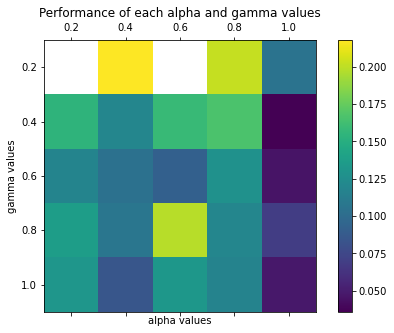

In [6]:
file_name = 'sokoban01.txt'
t_performance, opt_a, opt_g, opt_eps_d = parameter_tuning(file_name=file_name)
visualize_param_tuning('sokoban01.txt',t_performance[0],'eps_decay rate',np.median(opt_eps_d))